# Malaria Detection with VGG19 (Improved Pipeline)

This notebook implements a robust Transfer Learning pipeline for Malaria Cell classification. 

### Key Features & Improvements:
1.  **Correct Preprocessing**: Uses `tf.keras.applications.vgg19.preprocess_input` (zero-centering, BGR) instead of raw `1./255` scaling, which matches how VGG19 was originally trained.
2.  **Stratified Splitting**: Ensures train/val/test sets preserve the class imbalance ratio.
3.  **Class Weighting**: Penalizes the model more for missing the minority (Positive) class.
4.  **Simplified Architecture**: Uses `GlobalAveragePooling` and a simpler Dense head to reduce overfitting compared to complex MLPs.
5.  **Optimal Threshold Tuning**: Automatically finds the best probability threshold (e.g., 0.3 vs 0.5) to maximize F1-score.
6.  **Two-Phase Training**: 
    * *Phase 1*: Train only the top layers.
    * *Phase 2*: Fine-tune the last block of VGG19.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, auc, accuracy_score, precision_score, recall_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input # <--- CRITICAL IMPROVEMENT
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC

print("=" * 70)
print("SYSTEM CHECK")
print("=" * 70)
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("TensorFlow Version:", tf.__version__)

2025-12-16 15:05:22.099337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-16 15:05:22.110143: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-16 15:05:22.113391: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-16 15:05:22.121557: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-16 15:05:22.686134: W tensorflow/compiler/tf2

SYSTEM CHECK
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
TensorFlow Version: 2.17.0


I0000 00:00:1765868723.285323  846531 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1765868723.287137  846531 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1765868723.321102  846531 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1765868723.322519  846531 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

## 1. Configuration
Set your dataset paths here.

In [2]:
# UPDATE THIS PATH TO YOUR DATASET LOCATION
DATASET_PATH = '/home/user1/musab_2025/dataset/MalariaDataset'

NEGATIVE_PATH = os.path.join(DATASET_PATH, 'Negative')
POSITIVE_PATH = os.path.join(DATASET_PATH, 'Positive')

# Model parameters
IMG_SIZE = 224  # VGG19 standard input size
BATCH_SIZE = 16
EPOCHS_PHASE1 = 50  # Transfer learning
EPOCHS_PHASE2 = 20  # Fine-tuning
LEARNING_RATE_PHASE1 = 0.001
LEARNING_RATE_PHASE2 = 1e-5

# Data split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# XLA optimization (optional, helps with some GPU errors)
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

## 2. Load and Split Dataset
We use Stratified Splitting to keep the ratio of Positive/Negative samples consistent across Train, Validation, and Test sets.

In [3]:
print("Loading file paths...")

# Load image paths and labels
negative_images = [os.path.join(NEGATIVE_PATH, f) for f in os.listdir(NEGATIVE_PATH) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
positive_images = [os.path.join(POSITIVE_PATH, f) for f in os.listdir(POSITIVE_PATH) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Create labels (0 = negative, 1 = positive)
image_paths = negative_images + positive_images
labels = [0] * len(negative_images) + [1] * len(positive_images)

# Convert to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

print(f"✓ Total images: {len(image_paths)}")
print(f"✓ Class imbalance ratio: {len(negative_images) / len(positive_images):.2f}:1")

# First split: separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, 
    test_size=TEST_RATIO, 
    stratify=labels, 
    random_state=42
)

# Second split: divide remaining into train and val
val_size_adjusted = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=val_size_adjusted, 
    stratify=y_temp, 
    random_state=42
)

print(f"✓ Training set: {len(X_train)} ({len(X_train)/len(image_paths)*100:.1f}%)")
print(f"✓ Validation set: {len(X_val)} ({len(X_val)/len(image_paths)*100:.1f}%)")
print(f"✓ Test set: {len(X_test)} ({len(X_test)/len(image_paths)*100:.1f}%)")

Loading file paths...
✓ Total images: 2990
✓ Class imbalance ratio: 2.51:1
✓ Training set: 2092 (70.0%)
✓ Validation set: 449 (15.0%)
✓ Test set: 449 (15.0%)


## 3. Compute Class Weights
Because the dataset is imbalanced, we compute weights so the model pays more attention to the minority class.

In [4]:
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print(f"Class Weights: {class_weights}")
print(f"Positive samples will be weighted {class_weights[1]/class_weights[0]:.2f}x more than negative ones.")

Class Weights: {0: 0.6991978609625669, 1: 1.75503355704698}
Positive samples will be weighted 2.51x more than negative ones.


## 4. Data Generators (Improved)
**Improvement:** We removed `rescale=1./255` and added `preprocessing_function=preprocess_input`. 

VGG19 expects inputs to be zero-centered with BGR channel ordering, not just scaled 0-1 RGB.

In [5]:
# Helper function to create dataframe
def create_dataframe(paths, labels):
    return pd.DataFrame({'filename': paths, 'class': labels.astype(str)})

train_df = create_dataframe(X_train, y_train)
val_df = create_dataframe(X_val, y_val)
test_df = create_dataframe(X_test, y_test)

# Generator with VGG19 Preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # <--- CORRECT VGG19 PREPROCESSING
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input   # <--- CORRECT VGG19 PREPROCESSING
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 2092 validated image filenames belonging to 2 classes.
Found 449 validated image filenames belonging to 2 classes.
Found 449 validated image filenames belonging to 2 classes.


## 5. Build Model (Improved Architecture)
**Improvement:** We simplify the head. VGG19 is a strong feature extractor; adding too many Dense layers on top (like `512 -> 256 -> 128`) causes overfitting on small datasets. We use GlobalAveragePooling + One Dense Layer.

In [6]:
def build_improved_vgg19(input_shape=(IMG_SIZE, IMG_SIZE, 3), trainable_base=False):
    # Load pre-trained VGG19
    base_model = VGG19(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False
    )
    
    base_model.trainable = trainable_base

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),          # Reduces parameters heavily, prevents overfitting
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),                      # Strong dropout
        layers.Dense(1, activation='sigmoid')     # Output layer
    ])
    
    return model, base_model

model, base_model = build_improved_vgg19()
model.summary()

I0000 00:00:1765868755.054227  846531 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1765868755.055272  846531 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1765868755.056253  846531 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1765868755.057327  846531 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,156,993 (76.89 MB)

 Trainable params: 132,097 (516.00 KB)

 Non-trainable params: 20,024,896 (76.39 MB)

## 6. Phase 1: Transfer Learning
Train only the top layers while the base VGG19 is frozen.

In [7]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE1),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1),
    ModelCheckpoint('malaria_vgg19_phase1.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)
]

history_phase1 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE1,
    validation_data=val_generator,
    callbacks=callbacks_phase1,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/50


I0000 00:00:1765868762.626693  846848 service.cc:146] XLA service 0x723ba8003770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765868762.626724  846848 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1765868762.626729  846848 service.cc:154]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-12-16 15:06:02.711849: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-16 15:06:03.136470: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  1/131 ━━━━━━━━━━━━━━━━━━━━ 11:23 5s/step - accuracy: 0.6250 - auc: 0.6410 - loss: 1.0601 - precision: 0.3333 - recall: 1.0000

I0000 00:00:1765868766.111657  846848 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.7700 - auc: 0.8632 - loss: 0.7836 - precision: 0.5653 - recall: 0.8371
Epoch 1: val_auc improved from None to 0.97480, saving model to malaria_vgg19_phase1.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 75s 539ms/step - accuracy: 0.8279 - auc: 0.9244 - loss: 0.6400 - precision: 0.6443 - recall: 0.8842 - val_accuracy: 0.9376 - val_auc: 0.9748 - val_loss: 0.4082 - val_precision: 0.9310 - val_recall: 0.8438 - learning_rate: 0.0010
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8897 - auc: 0.9523 - loss: 0.5223 - precision: 0.7552 - recall: 0.9190
Epoch 2: val_auc improved from 0.97480 to 0.97659, saving model to malaria_vgg19_phase1.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 508ms/step - accuracy: 0.8872 - auc: 0.9552 - loss: 0.5036 - precision: 0.7479 - recall: 0.9111 - val_accuracy: 0.8998 - val_auc: 0.9766 - val_loss: 0.4543 - val_precision: 0.7546 - val_recall: 0.9609 - learning_rate: 0.0010
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9064 - auc: 0.9596 - loss: 0.4603 - precision: 0.7895 - recall: 0.9056
Epoch 3: val_auc did not improve from 0.97659
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 513ms/step - accuracy: 0.9044 - auc: 0.9584 - loss: 0.4603 - precision: 0.7886 - recall: 0.9077 - val_accuracy: 0.9599 - val_auc: 0.9755 - val_loss: 0.3542 - val_precision: 0.9231 - val_recall: 0.9375 - learning_rate: 0.0010
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9055 - auc: 0.9661 - loss: 0.4237 - precision: 0.7857 - recall: 0.9223
Epoch 4: val_auc did not improve from 0.97659
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 503ms/step - accuracy: 0.9054 - auc: 0.9638 - loss: 0.4256 - precision: 0.7867 - 

131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 508ms/step - accuracy: 0.9159 - auc: 0.9680 - loss: 0.3705 - precision: 0.8201 - recall: 0.9027 - val_accuracy: 0.9488 - val_auc: 0.9775 - val_loss: 0.2886 - val_precision: 0.9134 - val_recall: 0.9062 - learning_rate: 0.0010
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9129 - auc: 0.9666 - loss: 0.3634 - precision: 0.7990 - recall: 0.9095
Epoch 8: val_auc did not improve from 0.97750
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 509ms/step - accuracy: 0.9197 - auc: 0.9708 - loss: 0.3481 - precision: 0.8252 - recall: 0.9111 - val_accuracy: 0.9488 - val_auc: 0.9756 - val_loss: 0.2809 - val_precision: 0.9268 - val_recall: 0.8906 - learning_rate: 0.0010
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9084 - auc: 0.9701 - loss: 0.3432 - precision: 0.7911 - recall: 0.9078
Epoch 9: val_auc improved from 0.97750 to 0.97765, saving model to malaria_vgg19_phase1.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.9168 - auc: 0.9707 - loss: 0.3400 - precision: 0.8168 - recall: 0.9128 - val_accuracy: 0.9577 - val_auc: 0.9776 - val_loss: 0.2653 - val_precision: 0.9225 - val_recall: 0.9297 - learning_rate: 0.0010
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9349 - auc: 0.9810 - loss: 0.2910 - precision: 0.8364 - recall: 0.9467
Epoch 10: val_auc did not improve from 0.97765
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 501ms/step - accuracy: 0.9326 - auc: 0.9764 - loss: 0.3108 - precision: 0.8452 - recall: 0.9346 - val_accuracy: 0.9310 - val_auc: 0.9766 - val_loss: 0.3204 - val_precision: 0.8255 - val_recall: 0.9609 - learning_rate: 0.0010
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9160 - auc: 0.9692 - loss: 0.3458 - precision: 0.8307 - recall: 0.8990
Epoch 11: val_auc did not improve from 0.97765
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 503ms/step - accuracy: 0.9183 - auc: 0.9731 - loss: 0.3232 - precision: 0.819

131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 514ms/step - accuracy: 0.9159 - auc: 0.9688 - loss: 0.3314 - precision: 0.8201 - recall: 0.9027 - val_accuracy: 0.9577 - val_auc: 0.9787 - val_loss: 0.2449 - val_precision: 0.9431 - val_recall: 0.9062 - learning_rate: 0.0010
Epoch 13/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.9186 - auc: 0.9752 - loss: 0.3064 - precision: 0.8271 - recall: 0.9115
Epoch 13: val_auc did not improve from 0.97872
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 508ms/step - accuracy: 0.9192 - auc: 0.9735 - loss: 0.3091 - precision: 0.8290 - recall: 0.9027 - val_accuracy: 0.9488 - val_auc: 0.9774 - val_loss: 0.2734 - val_precision: 0.8777 - val_recall: 0.9531 - learning_rate: 0.0010
Epoch 14/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9292 - auc: 0.9766 - loss: 0.2933 - precision: 0.8420 - recall: 0.9376
Epoch 14: val_auc did not improve from 0.97872
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 507ms/step - accuracy: 0.9273 - auc: 0.9781 - loss: 0.2870 - precision: 0.831

131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 504ms/step - accuracy: 0.9216 - auc: 0.9714 - loss: 0.3018 - precision: 0.8283 - recall: 0.9144 - val_accuracy: 0.9532 - val_auc: 0.9802 - val_loss: 0.2309 - val_precision: 0.9213 - val_recall: 0.9141 - learning_rate: 5.0000e-04
Epoch 18/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9394 - auc: 0.9823 - loss: 0.2562 - precision: 0.8555 - recall: 0.9484
Epoch 18: val_auc improved from 0.98018 to 0.98152, saving model to malaria_vgg19_phase1.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 506ms/step - accuracy: 0.9321 - auc: 0.9771 - loss: 0.2744 - precision: 0.8439 - recall: 0.9346 - val_accuracy: 0.9510 - val_auc: 0.9815 - val_loss: 0.2266 - val_precision: 0.9492 - val_recall: 0.8750 - learning_rate: 5.0000e-04
Epoch 19/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9356 - auc: 0.9822 - loss: 0.2499 - precision: 0.8586 - recall: 0.9237
Epoch 19: val_auc did not improve from 0.98152
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 495ms/step - accuracy: 0.9326 - auc: 0.9782 - loss: 0.2666 - precision: 0.8583 - recall: 0.9144 - val_accuracy: 0.9555 - val_auc: 0.9809 - val_loss: 0.2184 - val_precision: 0.9576 - val_recall: 0.8828 - learning_rate: 5.0000e-04
Epoch 20/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.9201 - auc: 0.9681 - loss: 0.3007 - precision: 0.8082 - recall: 0.9256
Epoch 20: val_auc did not improve from 0.98152
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 515ms/step - accuracy: 0.9235 - auc: 0.9747 - loss: 0.2799 - precisio

131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 507ms/step - accuracy: 0.9383 - auc: 0.9756 - loss: 0.2575 - precision: 0.8666 - recall: 0.9262 - val_accuracy: 0.9243 - val_auc: 0.9851 - val_loss: 0.2709 - val_precision: 0.8013 - val_recall: 0.9766 - learning_rate: 5.0000e-04
Epoch 26/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9365 - auc: 0.9824 - loss: 0.2317 - precision: 0.8496 - recall: 0.9358
Epoch 26: val_auc did not improve from 0.98514
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 509ms/step - accuracy: 0.9407 - auc: 0.9779 - loss: 0.2490 - precision: 0.8734 - recall: 0.9262 - val_accuracy: 0.9577 - val_auc: 0.9808 - val_loss: 0.2062 - val_precision: 0.9098 - val_recall: 0.9453 - learning_rate: 5.0000e-04
Epoch 27/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9382 - auc: 0.9781 - loss: 0.2479 - precision: 0.8654 - recall: 0.9247
Epoch 27: val_auc did not improve from 0.98514
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.9369 - auc: 0.9788 - loss: 0.2462 - precisio

131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 501ms/step - accuracy: 0.9336 - auc: 0.9818 - loss: 0.2268 - precision: 0.8467 - recall: 0.9362 - val_accuracy: 0.9644 - val_auc: 0.9853 - val_loss: 0.1811 - val_precision: 0.9242 - val_recall: 0.9531 - learning_rate: 2.5000e-04
Epoch 34/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9395 - auc: 0.9801 - loss: 0.2349 - precision: 0.8660 - recall: 0.9301
Epoch 34: val_auc did not improve from 0.98535
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 499ms/step - accuracy: 0.9407 - auc: 0.9791 - loss: 0.2369 - precision: 0.8711 - recall: 0.9295 - val_accuracy: 0.9621 - val_auc: 0.9834 - val_loss: 0.1785 - val_precision: 0.9237 - val_recall: 0.9453 - learning_rate: 2.5000e-04
Epoch 35/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9419 - auc: 0.9866 - loss: 0.2055 - precision: 0.8627 - recall: 0.9439
Epoch 35: val_auc did not improve from 0.98535
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.9402 - auc: 0.9855 - loss: 0.2102 - precisio

131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 508ms/step - accuracy: 0.9383 - auc: 0.9831 - loss: 0.2168 - precision: 0.8643 - recall: 0.9295 - val_accuracy: 0.9644 - val_auc: 0.9859 - val_loss: 0.1875 - val_precision: 0.9179 - val_recall: 0.9609 - learning_rate: 2.5000e-04
Epoch 38/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9453 - auc: 0.9816 - loss: 0.2228 - precision: 0.8827 - recall: 0.9342
Epoch 38: val_auc did not improve from 0.98594
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.9436 - auc: 0.9836 - loss: 0.2143 - precision: 0.8700 - recall: 0.9430 - val_accuracy: 0.9644 - val_auc: 0.9842 - val_loss: 0.1753 - val_precision: 0.9308 - val_recall: 0.9453 - learning_rate: 2.5000e-04
Epoch 39/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9417 - auc: 0.9851 - loss: 0.2017 - precision: 0.8684 - recall: 0.9394
Epoch 39: val_auc improved from 0.98594 to 0.98598, saving model to malaria_vgg19_phase1.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 498ms/step - accuracy: 0.9316 - auc: 0.9777 - loss: 0.2335 - precision: 0.8490 - recall: 0.9245 - val_accuracy: 0.9599 - val_auc: 0.9860 - val_loss: 0.1782 - val_precision: 0.9167 - val_recall: 0.9453 - learning_rate: 2.5000e-04
Epoch 40/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9511 - auc: 0.9879 - loss: 0.1908 - precision: 0.8830 - recall: 0.9564
Epoch 40: val_auc improved from 0.98598 to 0.98694, saving model to malaria_vgg19_phase1.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 500ms/step - accuracy: 0.9417 - auc: 0.9833 - loss: 0.2114 - precision: 0.8646 - recall: 0.9430 - val_accuracy: 0.9621 - val_auc: 0.9869 - val_loss: 0.1811 - val_precision: 0.9173 - val_recall: 0.9531 - learning_rate: 2.5000e-04
Epoch 41/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9276 - auc: 0.9783 - loss: 0.2356 - precision: 0.8314 - recall: 0.9275
Epoch 41: val_auc did not improve from 0.98694
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 503ms/step - accuracy: 0.9297 - auc: 0.9761 - loss: 0.2412 - precision: 0.8459 - recall: 0.9211 - val_accuracy: 0.9510 - val_auc: 0.9834 - val_loss: 0.2232 - val_precision: 0.8681 - val_recall: 0.9766 - learning_rate: 2.5000e-04
Epoch 42/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9394 - auc: 0.9837 - loss: 0.2114 - precision: 0.8588 - recall: 0.9380
Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 42: val_auc did not improve from 0.98694
131/131 ━━━━━━━━━━━━━━━━

## 7. Phase 2: Fine-Tuning
Unfreeze the last convolutional block of VGG19 and train with a very low learning rate.

In [8]:
base_model.trainable = True

# Unfreeze only the last 4 layers (Block 5)
fine_tune_at = len(base_model.layers) - 4
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Unfrozen layers starting from index: {fine_tune_at}")

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE_PHASE2),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint('malaria_vgg19_final.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)
]

history_phase2 = model.fit(
    train_generator,
    epochs=EPOCHS_PHASE2,
    validation_data=val_generator,
    callbacks=callbacks_phase2,
    class_weight=class_weights,
    verbose=1
)

Unfrozen layers starting from index: 18
Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9348 - auc: 0.9818 - loss: 0.2094 - precision: 0.8448 - recall: 0.9435
Epoch 1: val_auc improved from None to 0.98862, saving model to malaria_vgg19_final.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 73s 529ms/step - accuracy: 0.9412 - auc: 0.9839 - loss: 0.2002 - precision: 0.8600 - recall: 0.9480 - val_accuracy: 0.9710 - val_auc: 0.9886 - val_loss: 0.1455 - val_precision: 0.9832 - val_recall: 0.9141
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9521 - auc: 0.9911 - loss: 0.1626 - precision: 0.8794 - recall: 0.9597
Epoch 2: val_auc improved from 0.98862 to 0.99061, saving model to malaria_vgg19_final.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 518ms/step - accuracy: 0.9465 - auc: 0.9866 - loss: 0.1849 - precision: 0.8700 - recall: 0.9547 - val_accuracy: 0.9621 - val_auc: 0.9906 - val_loss: 0.1523 - val_precision: 0.8993 - val_recall: 0.9766
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9600 - auc: 0.9907 - loss: 0.1577 - precision: 0.9003 - recall: 0.9650
Epoch 3: val_auc did not improve from 0.99061
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.9584 - auc: 0.9921 - loss: 0.1518 - precision: 0.8934 - recall: 0.9698 - val_accuracy: 0.9599 - val_auc: 0.9898 - val_loss: 0.1677 - val_precision: 0.8873 - val_recall: 0.9844
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9579 - auc: 0.9943 - loss: 0.1417 - precision: 0.8892 - recall: 0.9735
Epoch 4: val_auc did not improve from 0.99061
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 501ms/step - accuracy: 0.9627 - auc: 0.9947 - loss: 0.1367 - precision: 0.9085 - recall: 0.9664 - val_accuracy: 0.9755 - val_auc:

131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 503ms/step - accuracy: 0.9661 - auc: 0.9928 - loss: 0.1412 - precision: 0.9187 - recall: 0.9664 - val_accuracy: 0.9800 - val_auc: 0.9933 - val_loss: 0.1209 - val_precision: 0.9542 - val_recall: 0.9766
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9770 - auc: 0.9939 - loss: 0.1251 - precision: 0.9591 - recall: 0.9628
Epoch 6: val_auc did not improve from 0.99334
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 503ms/step - accuracy: 0.9699 - auc: 0.9935 - loss: 0.1302 - precision: 0.9319 - recall: 0.9648 - val_accuracy: 0.9688 - val_auc: 0.9928 - val_loss: 0.1315 - val_precision: 0.9254 - val_recall: 0.9688
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9775 - auc: 0.9980 - loss: 0.1020 - precision: 0.9413 - recall: 0.9837
Epoch 7: val_auc improved from 0.99334 to 0.99381, saving model to malaria_vgg19_final.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 499ms/step - accuracy: 0.9771 - auc: 0.9971 - loss: 0.1084 - precision: 0.9419 - recall: 0.9799 - val_accuracy: 0.9866 - val_auc: 0.9938 - val_loss: 0.1091 - val_precision: 0.9841 - val_recall: 0.9688
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9739 - auc: 0.9969 - loss: 0.1098 - precision: 0.9370 - recall: 0.9748
Epoch 8: val_auc did not improve from 0.99381
131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 499ms/step - accuracy: 0.9661 - auc: 0.9946 - loss: 0.1298 - precision: 0.9187 - recall: 0.9664 - val_accuracy: 0.9844 - val_auc: 0.9911 - val_loss: 0.1050 - val_precision: 0.9919 - val_recall: 0.9531
Epoch 9/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9782 - auc: 0.9957 - loss: 0.1134 - precision: 0.9484 - recall: 0.9762
Epoch 9: val_auc improved from 0.99381 to 0.99443, saving model to malaria_vgg19_final.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 506ms/step - accuracy: 0.9751 - auc: 0.9958 - loss: 0.1169 - precision: 0.9416 - recall: 0.9732 - val_accuracy: 0.9844 - val_auc: 0.9944 - val_loss: 0.0925 - val_precision: 0.9764 - val_recall: 0.9688
Epoch 10/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9665 - auc: 0.9961 - loss: 0.1214 - precision: 0.9070 - recall: 0.9785
Epoch 10: val_auc did not improve from 0.99443
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.9661 - auc: 0.9955 - loss: 0.1256 - precision: 0.9147 - recall: 0.9715 - val_accuracy: 0.9555 - val_auc: 0.9907 - val_loss: 0.1663 - val_precision: 0.8750 - val_recall: 0.9844
Epoch 11/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9712 - auc: 0.9981 - loss: 0.1027 - precision: 0.9288 - recall: 0.9752
Epoch 11: val_auc improved from 0.99443 to 0.99496, saving model to malaria_vgg19_final.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 512ms/step - accuracy: 0.9704 - auc: 0.9972 - loss: 0.1097 - precision: 0.9306 - recall: 0.9681 - val_accuracy: 0.9822 - val_auc: 0.9950 - val_loss: 0.1135 - val_precision: 0.9839 - val_recall: 0.9531
Epoch 12/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9799 - auc: 0.9967 - loss: 0.1068 - precision: 0.9507 - recall: 0.9815
Epoch 12: val_auc improved from 0.99496 to 0.99546, saving model to malaria_vgg19_final.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 65s 498ms/step - accuracy: 0.9747 - auc: 0.9973 - loss: 0.1045 - precision: 0.9330 - recall: 0.9815 - val_accuracy: 0.9822 - val_auc: 0.9955 - val_loss: 0.1186 - val_precision: 0.9918 - val_recall: 0.9453
Epoch 13/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9738 - auc: 0.9978 - loss: 0.0997 - precision: 0.9379 - recall: 0.9704
Epoch 13: val_auc did not improve from 0.99546
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 505ms/step - accuracy: 0.9780 - auc: 0.9978 - loss: 0.0981 - precision: 0.9479 - recall: 0.9765 - val_accuracy: 0.9889 - val_auc: 0.9949 - val_loss: 0.0901 - val_precision: 0.9843 - val_recall: 0.9766
Epoch 14/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9657 - auc: 0.9947 - loss: 0.1277 - precision: 0.9134 - recall: 0.9696
Epoch 14: val_auc improved from 0.99546 to 0.99549, saving model to malaria_vgg19_final.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 504ms/step - accuracy: 0.9665 - auc: 0.9947 - loss: 0.1270 - precision: 0.9161 - recall: 0.9715 - val_accuracy: 0.9911 - val_auc: 0.9955 - val_loss: 0.0884 - val_precision: 1.0000 - val_recall: 0.9688
Epoch 15/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9794 - auc: 0.9977 - loss: 0.0979 - precision: 0.9404 - recall: 0.9834
Epoch 15: val_auc did not improve from 0.99549
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.9780 - auc: 0.9969 - loss: 0.1021 - precision: 0.9421 - recall: 0.9832 - val_accuracy: 0.9889 - val_auc: 0.9949 - val_loss: 0.0888 - val_precision: 0.9843 - val_recall: 0.9766
Epoch 16/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9785 - auc: 0.9980 - loss: 0.0987 - precision: 0.9369 - recall: 0.9874
Epoch 16: val_auc did not improve from 0.99549
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 504ms/step - accuracy: 0.9780 - auc: 0.9984 - loss: 0.0936 - precision: 0.9435 - recall: 0.9815 - val_accuracy: 0.9844 - val_

131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 508ms/step - accuracy: 0.9823 - auc: 0.9985 - loss: 0.0864 - precision: 0.9560 - recall: 0.9832 - val_accuracy: 0.9889 - val_auc: 0.9976 - val_loss: 0.0912 - val_precision: 0.9767 - val_recall: 0.9844
Epoch 18/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9851 - auc: 0.9991 - loss: 0.0800 - precision: 0.9642 - recall: 0.9839
Epoch 18: val_auc improved from 0.99758 to 0.99937, saving model to malaria_vgg19_final.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 509ms/step - accuracy: 0.9794 - auc: 0.9985 - loss: 0.0877 - precision: 0.9496 - recall: 0.9799 - val_accuracy: 0.9866 - val_auc: 0.9994 - val_loss: 0.0708 - val_precision: 0.9919 - val_recall: 0.9609
Epoch 19/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9819 - auc: 0.9992 - loss: 0.0815 - precision: 0.9452 - recall: 0.9942
Epoch 19: val_auc did not improve from 0.99937
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 512ms/step - accuracy: 0.9828 - auc: 0.9990 - loss: 0.0825 - precision: 0.9516 - recall: 0.9899 - val_accuracy: 0.9911 - val_auc: 0.9991 - val_loss: 0.0623 - val_precision: 1.0000 - val_recall: 0.9688
Epoch 20/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9852 - auc: 0.9993 - loss: 0.0796 - precision: 0.9695 - recall: 0.9800
Epoch 20: val_auc did not improve from 0.99937
131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 515ms/step - accuracy: 0.9818 - auc: 0.9992 - loss: 0.0783 - precision: 0.9529 - recall: 0.9849 - val_accuracy: 0.9844 - val_

## 8. Optimal Threshold Tuning (Crucial for Imbalance)
**Improvement:** Instead of assuming `0.5` is the best cutoff, we calculate the F1-score for all possible thresholds on the **Validation Set** and pick the one that gives the best balance.

Finding optimal threshold using Validation Set...
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step

🏆 Best F1-Score on Validation: 0.9922
✓ Optimal Decision Threshold: 0.3156


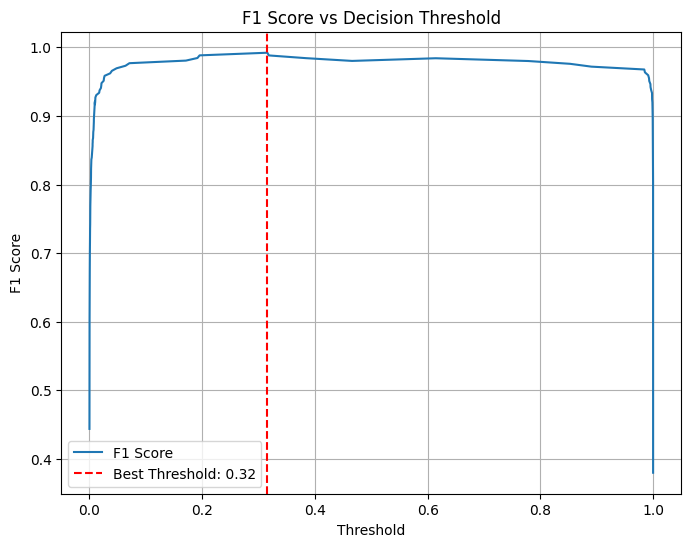

In [9]:
print("Finding optimal threshold using Validation Set...")

# Get predictions on Validation set
val_generator.reset()
val_preds_probs = model.predict(val_generator, verbose=1)
y_val_true = val_generator.classes

# Calculate Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(y_val_true, val_preds_probs)

# Calculate F1 Scores for every threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Find the index of the best F1 score
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n🏆 Best F1-Score on Validation: {best_f1:.4f}")
print(f"✓ Optimal Decision Threshold: {best_threshold:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.title('F1 Score vs Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

## 9. Final Evaluation on Test Set
We evaluate the model using the **Optimal Threshold** found above.

Evaluating on Test Set...
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 358ms/step

CLASSIFICATION REPORT (With Optimized Threshold)
              precision    recall  f1-score   support

    Negative       0.98      0.99      0.99       321
    Positive       0.98      0.95      0.96       128

    accuracy                           0.98       449
   macro avg       0.98      0.97      0.98       449
weighted avg       0.98      0.98      0.98       449

Accuracy:  0.9800
Recall:    0.9531
Precision: 0.9760
F1 Score:  0.9644


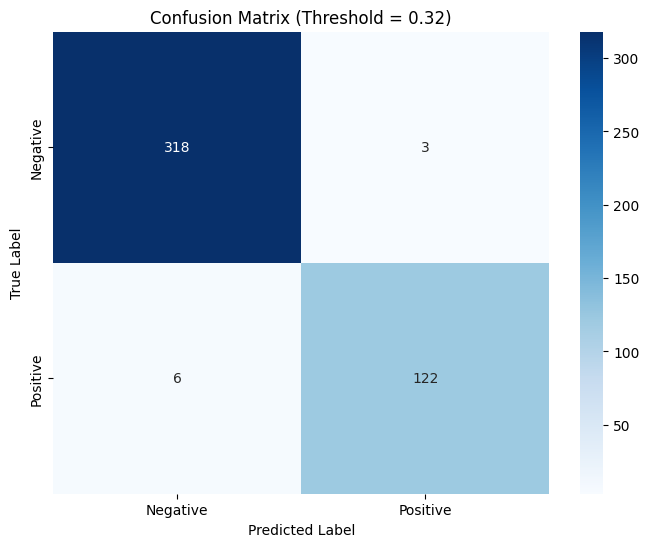

In [10]:
print("Evaluating on Test Set...")

test_generator.reset()
test_probs = model.predict(test_generator, verbose=1)

# Apply the OPTIMAL THRESHOLD (not 0.5)
test_preds = (test_probs.flatten() > best_threshold).astype(int)

print("\n" + "="*50)
print("CLASSIFICATION REPORT (With Optimized Threshold)")
print("="*50)
print(classification_report(y_test, test_preds, target_names=['Negative', 'Positive']))

print(f"Accuracy:  {accuracy_score(y_test, test_preds):.4f}")
print(f"Recall:    {recall_score(y_test, test_preds):.4f}")
print(f"Precision: {precision_score(y_test, test_preds):.4f}")
print(f"F1 Score:  {f1_score(y_test, test_preds):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix (Threshold = {best_threshold:.2f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [12]:
# target_recall = 0.98  # We want to catch 98% of positive cases
print("Finding threshold for 98% Recall...")

# Get Validation predictions again
val_preds_probs = model.predict(val_generator)
y_val_true = val_generator.classes

precisions, recalls, thresholds = precision_recall_curve(y_val_true, val_preds_probs)

# Find the largest threshold where Recall is still >= 0.98
# We scan from high threshold to low
safe_threshold = 0.5 # Default fallback
for t, r in zip(thresholds, recalls):
    if r >= 0.98:
        safe_threshold = t
    else:
        # Since thresholds are sorted, once recall drops below 0.98, we stop? 
        # Actually precision_recall_curve returns sorted by threshold usually.
        # It's safer to just filter the arrays:
        pass

# Robust way:
valid_indices = np.where(recalls >= 0.98)[0]
if len(valid_indices) > 0:
    # Pick the index with the highest Precision among those with enough Recall
    best_idx = valid_indices[np.argmax(precisions[valid_indices])]
    safe_threshold = thresholds[best_idx]
else:
    print("Could not achieve 98% recall. Picking max recall possible.")
    safe_threshold = thresholds[np.argmax(recalls)]

print(f"✓ New Safety Threshold: {safe_threshold:.4f}")
print("Applying to Test Set...")

test_preds_safe = (test_probs.flatten() > safe_threshold).astype(int)
print(classification_report(y_test, test_preds_safe, target_names=['Negative', 'Positive']))


Finding threshold for 98% Recall...
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step
✓ New Safety Threshold: 0.3156
Applying to Test Set...
              precision    recall  f1-score   support

    Negative       0.98      0.99      0.99       321
    Positive       0.98      0.95      0.96       128

    accuracy                           0.98       449
   macro avg       0.98      0.97      0.98       449
weighted avg       0.98      0.98      0.98       449



In [13]:
# Force threshold to 1%
print("Testing Extreme Threshold (0.01)...")
test_preds_extreme = (test_probs.flatten() > 0.01).astype(int)

print(classification_report(y_test, test_preds_extreme, target_names=['Negative', 'Positive']))

Testing Extreme Threshold (0.01)...
              precision    recall  f1-score   support

    Negative       1.00      0.94      0.97       321
    Positive       0.87      0.99      0.93       128

    accuracy                           0.96       449
   macro avg       0.93      0.97      0.95       449
weighted avg       0.96      0.96      0.96       449



In [14]:
from sklearn.metrics import precision_recall_curve

def find_safety_threshold(model, generator, min_recall=0.99):
    """
    Finds the highest threshold that still guarantees the specified minimum recall.
    """
    print(f"Searching for threshold that guarantees {min_recall:.0%} Recall...")
    
    # Get predictions
    generator.reset()
    y_pred_probs = model.predict(generator, verbose=1)
    y_true = generator.classes
    
    # Calculate Precision-Recall Curve
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_probs)
    
    # Filter for thresholds that meet the recall requirement
    # We look for the last index where recall is >= min_recall
    valid_indices = [i for i, r in enumerate(recalls) if r >= min_recall]
    
    if not valid_indices:
        print("Warning: Model cannot achieve the desired recall. returning minimum threshold.")
        return thresholds[0]
        
    # We pick the threshold that gives the highest precision among the valid ones
    best_idx = valid_indices[np.argmax(precisions[valid_indices])]
    
    # Sometimes precision_recall_curve returns thresholds with length = len(precisions) - 1
    if best_idx < len(thresholds):
        best_threshold = thresholds[best_idx]
    else:
        best_threshold = thresholds[-1]
        
    print(f"✓ Found Safety Threshold: {best_threshold:.5f}")
    return best_threshold

# ---------------------------------------------------------
# Usage
# ---------------------------------------------------------

# 1. Find the Sweet Spot using Validation Data
safety_threshold = find_safety_threshold(model, val_generator, min_recall=0.99)

# 2. Apply to Test Data
print("\nApplying Safety Threshold to Test Set...")
test_generator.reset()
test_probs = model.predict(test_generator, verbose=1)
test_preds_safety = (test_probs.flatten() > safety_threshold).astype(int)

# 3. Final Report
print("\n" + "="*50)
print(f"FINAL MEDICAL REPORT (Threshold = {safety_threshold:.5f})")
print("="*50)
print(classification_report(y_test, test_preds_safety, target_names=['Negative', 'Positive']))

Searching for threshold that guarantees 99% Recall...
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step
✓ Found Safety Threshold: 0.31558

Applying Safety Threshold to Test Set...
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 350ms/step

FINAL MEDICAL REPORT (Threshold = 0.31558)
              precision    recall  f1-score   support

    Negative       0.98      0.99      0.99       321
    Positive       0.98      0.95      0.96       128

    accuracy                           0.98       449
   macro avg       0.98      0.97      0.98       449
weighted avg       0.98      0.98      0.98       449



In [19]:
# Manually set the threshold to 0.1 based on analysis
final_threshold = 0.05

print(f"Applying Manual Safety Threshold: {final_threshold}")
test_generator.reset()
test_probs = model.predict(test_generator, verbose=1)
test_preds_final = (test_probs.flatten() > final_threshold).astype(int)

print("\n" + "="*50)
print(f"FINAL DEPLOYMENT REPORT (Threshold = {final_threshold})")
print("="*50)
print(classification_report(y_test, test_preds_final, target_names=['Negative', 'Positive']))


Applying Manual Safety Threshold: 0.05
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 355ms/step

FINAL DEPLOYMENT REPORT (Threshold = 0.05)
              precision    recall  f1-score   support

    Negative       0.99      0.98      0.99       321
    Positive       0.96      0.98      0.97       128

    accuracy                           0.98       449
   macro avg       0.98      0.98      0.98       449
weighted avg       0.98      0.98      0.98       449

